# Data Exploration 

Here we want to simply show the raw pattern on:
- Frames of bees growth
- Frames of brood growth 
- Frames of honey growth 
- Gentleness
- Varroa dynamic impact 
- Colonie survival
- Queen survival 

The output of this notebook is a grid chart for the annexe of the paper showing the cubee effect on different hive state attributes and prepare the formal modelisation.

In [11]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 

from matplotlib.offsetbox import AnchoredText
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import statsmodels.api as sm
from cubee.configs.filepath import formatted_datapath, raw_datapath

plt.style.use('seaborn-v0_8-poster')

### 0. Load formatted dataset

In [12]:
data = pd.read_csv(formatted_datapath)
data['death'] = data["state"].apply(lambda x: True if x < 1 else False)
data.head()

,time1,time2,state,hive_age,cubee,fob,fobr,foh,varroa,queen_age,queen_state,queen_id,brood_pattern,stings,hid,hive_interacted,death
0,0,30,1,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,0,False
1,30,59,1,39,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,0,False
2,59,89,1,74,0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,0,False
3,89,118,1,98,0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,1,False
4,118,148,1,125,1,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,1,False


### From long to short for quick Kaplan Meier

In [13]:
cubee_dose = data.groupby("hid")['cubee'].sum().reset_index()
states = data.groupby("hid")[['death','hive_age']].max().reset_index()
short = pd.merge(states,cubee_dose,on="hid",how="left")
short['cubee'] = short['cubee'].fillna(0)


In [14]:
#sns.distplot(cubee_dose['cubee'])

### 1. Quick look at survival

In [15]:
cubeed = short.loc[short['cubee']>1.0]
not_cubeed = short.loc[short['cubee']==0.0]

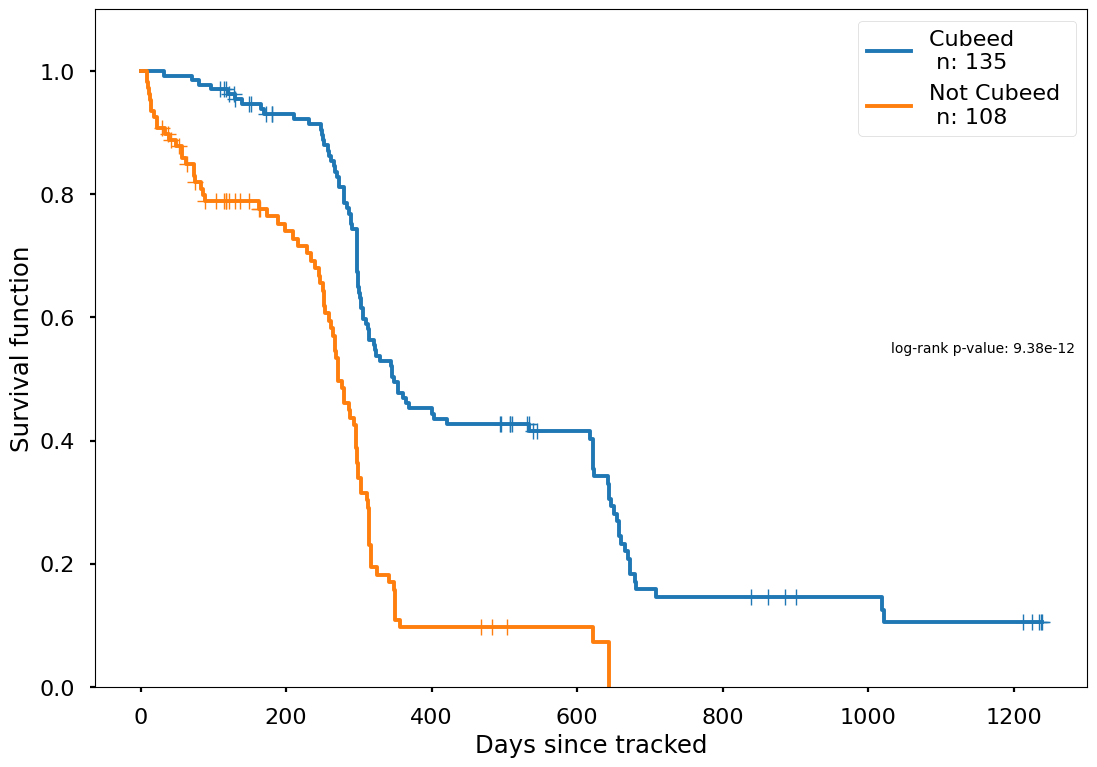

In [16]:
low_results=logrank_test(cubeed['hive_age'],not_cubeed['hive_age'],event_observed_A=cubeed['death'], event_observed_B=not_cubeed['death'])
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
ax = kmf.fit(cubeed['hive_age'], cubeed['death'], label=f"Cubeed \n n: {len(cubeed)}").plot(ax=ax, ci_show=False, show_censors=True)
ax = kmf.fit(not_cubeed['hive_age'], not_cubeed['death'], label=f"Not Cubeed \n n: {len(not_cubeed)}").plot(ax=ax, ci_show=False, show_censors=True)
ax.set_xlabel('Days since tracked')
ax.set_ylabel('Survival function')
plt.ylim([0, 1.1])
anchored_text = AnchoredText("log-rank p-value: {:.3}".format(low_results.p_value), loc=5, frameon=False)
ax.add_artist(anchored_text)
plt.savefig("KM-Global-Survival-logRank.png")

In [17]:
cubee_dose = data.groupby("queen_id")['cubee'].sum().reset_index()
cubee_dose.head()


,queen_id,cubee
0,150993_queen_0,0
1,150993_queen_1,7
2,150993_queen_2,2
3,150995_queen_0,3
4,150996_queen_0,9


In [18]:
states = data.groupby("queen_id")[['queen_state','queen_age']].max().reset_index()
short = pd.merge(states,cubee_dose,on="queen_id",how="left")
short['cubee'] = short['cubee'].fillna(0)

In [19]:
cubeed = short.loc[short['cubee']>0.0]
not_cubeed = short.loc[short['cubee']==0.0]

/Users/nico/Library/Caches/pypoetry/virtualenvs/cubee-YeWUf-Zc-py3.11/lib/python3.11/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/nico/Library/Caches/pypoetry/virtualenvs/cubee-YeWUf-Zc-py3.11/lib/python3.11/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


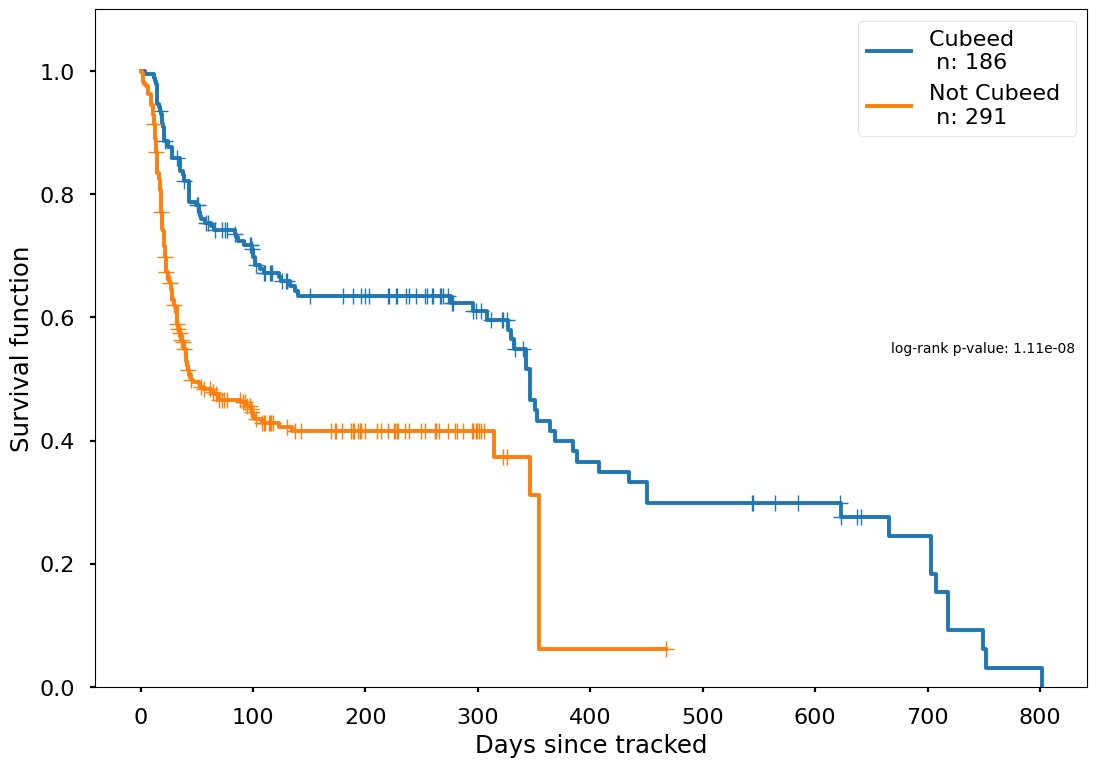

In [20]:
low_results=logrank_test(cubeed['queen_age'],not_cubeed['queen_age'],event_observed_A=cubeed['queen_state'], event_observed_B=not_cubeed['queen_state'])
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
ax = kmf.fit(cubeed['queen_age'], cubeed['queen_state'], label=f"Cubeed \n n: {len(cubeed)}").plot(ax=ax, ci_show=False, show_censors=True)
ax = kmf.fit(not_cubeed['queen_age'], not_cubeed['queen_state'], label=f"Not Cubeed \n n: {len(not_cubeed)}").plot(ax=ax, ci_show=False, show_censors=True)
ax.set_xlabel('Days since tracked')
ax.set_ylabel('Survival function')
plt.ylim([0, 1.1])
anchored_text = AnchoredText("log-rank p-value: {:.3}".format(low_results.p_value), loc=5, frameon=False)
ax.add_artist(anchored_text)
plt.savefig("KM-Queen-Survival-logRank.png")

### 2. Quick look at global fob, fobr, foh, stings, brood_pattern and varroa 

#### 2.1 Fob growth following supplementation

In [50]:
EFFECT_LENGTH_IN_MONTH = 6

In [51]:
data.groupby("hid")['cubee'].rolling(EFFECT_LENGTH_IN_MONTH).sum().reset_index().head(10)

,hid,level_1,cubee
0,46955,0,NaN
1,46955,1,NaN
2,46955,2,NaN
3,46955,3,NaN
4,46955,4,NaN
5,46955,5,1.0
6,46955,6,2.0
7,46955,7,2.0
8,46955,8,2.0
9,46955,9,2.0


In [52]:
data['applied_previous_month'] = data.groupby("hid")['cubee'].rolling(EFFECT_LENGTH_IN_MONTH).sum().reset_index()['cubee']
data['applied_previous_month'] = data['applied_previous_month'].fillna(0)
data['delta_fob'] = data.groupby("hid")['fob'].diff(-1)
data['delta_fobr'] = data.groupby("hid")['fobr'].diff(-1)
data['delta_foh'] = data.groupby("hid")['foh'].diff(-1)
data['delta_varroa'] = data.groupby("hid")['varroa'].diff(-1)
data['delta_brood_pattern'] = data.groupby("hid")['brood_pattern'].diff(-1)
data['delta_stings'] = data.groupby("hid")['stings'].diff(-1)

In [53]:
data['applied_previous_month'] = data['applied_previous_month'].apply(lambda x: "Supplemented" if x >0 else "Not supplemented")

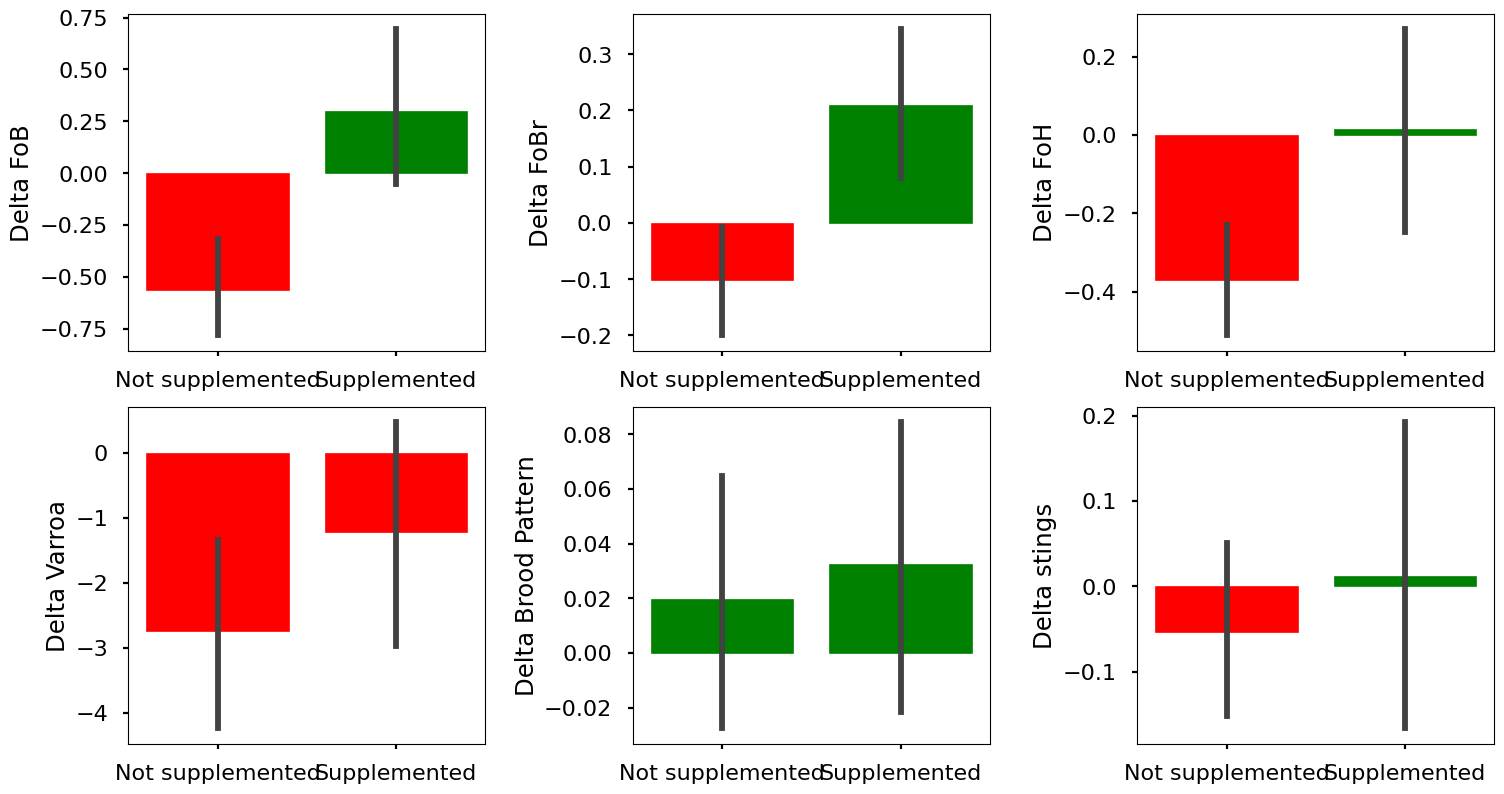

<Figure size 1280x880 with 0 Axes>

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
cols = ['delta_fob','delta_fobr','delta_foh','delta_varroa',
        'delta_brood_pattern','delta_stings']
names = ["Delta FoB", "Delta FoBr", "Delta FoH", "Delta Varroa","Delta Brood Pattern", "Delta stings"]
for i, (ax,col,nam) in enumerate(zip(axes, cols,names)):
    # bars = ax.bar(data['applied_previous_month'], data[col])
    bars = sns.barplot(x="applied_previous_month",y=col,data=data,ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel(nam)
    # Color bars based on values
    for bar in bars.containers[0].get_children():
        if bar.get_height() < 0:
            bar.set_color('red')
        elif bar.get_height() > 0:
            bar.set_color('green')
        # Optional: handle zero values
        else:
            bar.set_color('gray')
    
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
plt.savefig("Delta-HiveAttribute.png")

In [56]:
data['applied_previous_month'] = data.groupby("hid")['cubee'].rolling(EFFECT_LENGTH_IN_MONTH).sum().reset_index()['cubee']
data['applied_previous_month'] = data['applied_previous_month'].fillna(0)

In [57]:
X2 = sm.add_constant(data['applied_previous_month'].astype(int))
est = sm.OLS(data['delta_fob'] > 0, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_fob   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     32.70
Date:                Tue, 28 Oct 2025   Prob (F-statistic):           1.19e-08
Time:                        00:23:38   Log-Likelihood:                -1274.8
No. Observations:                2848   AIC:                             2554.
Df Residuals:                    2846   BIC:                             2565.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [58]:
X2 = sm.add_constant(data['applied_previous_month'].astype(int))
est = sm.OLS(data['delta_fobr'] > 0, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             delta_fobr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.239
Date:                Tue, 28 Oct 2025   Prob (F-statistic):              0.266
Time:                        00:23:40   Log-Likelihood:                -1218.2
No. Observations:                2848   AIC:                             2440.
Df Residuals:                    2846   BIC:                             2452.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [59]:
X2 = sm.add_constant(data['applied_previous_month'].astype(int))
est = sm.OLS(data['delta_varroa'] < 0, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           delta_varroa   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6809
Date:                Tue, 28 Oct 2025   Prob (F-statistic):              0.409
Time:                        00:23:40   Log-Likelihood:                 133.17
No. Observations:                2848   AIC:                            -262.3
Df Residuals:                    2846   BIC:                            -250.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [60]:
X2 = sm.add_constant(data['applied_previous_month'].astype(int))
est = sm.OLS(data['delta_brood_pattern'] >0 , X2)
est2 = est.fit()
print(est2.summary())

                             OLS Regression Results                            
Dep. Variable:     delta_brood_pattern   R-squared:                       0.001
Model:                             OLS   Adj. R-squared:                  0.001
Method:                  Least Squares   F-statistic:                     3.175
Date:                 Tue, 28 Oct 2025   Prob (F-statistic):             0.0749
Time:                         00:23:41   Log-Likelihood:                -1224.4
No. Observations:                 2848   AIC:                             2453.
Df Residuals:                     2846   BIC:                             2465.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const             

In [63]:
X2 = sm.add_constant(data['applied_previous_month'].astype(int))
est = sm.OLS(data['delta_stings'] < 0 , X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           delta_stings   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5865
Date:                Tue, 28 Oct 2025   Prob (F-statistic):              0.444
Time:                        00:23:58   Log-Likelihood:                -899.80
No. Observations:                2848   AIC:                             1804.
Df Residuals:                    2846   BIC:                             1816.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0